In [ ]:
!pip install -q transformers pytorch-lightning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 29.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 256
BATCH_SIZE = 16
LR = 2e-5
NUM_EPOCHS = 3

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", device)


Running on: cuda


In [ ]:
df = pd.read_csv('/content/drive/My Drive/fake_job_postings.csv')

# Drop missing and combine all text columns
df.fillna("", inplace=True)
df["text"] = (
    df["title"].astype(str) + " " +
    df["location"].astype(str) + " " +
    df["department"].astype(str) + " " +
    df["company_profile"].astype(str) + " " +
    df["description"].astype(str) + " " +
    df["requirements"].astype(str) + " " +
    df["benefits"].astype(str)
)


In [ ]:
df["label"] = df["fraudulent"].astype(int)
print(df["label"].value_counts(normalize=True) * 100)
print("Total samples:", len(df))


label
0    95.1566
1     4.8434
Name: proportion, dtype: float64
Total samples: 17880


In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)


In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
class BERTClassifier(pl.LightningModule):
    def __init__(self, n_classes, class_weights=None):
        super().__init__()
        self.save_hyperparameters()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.class_weights = class_weights

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        logits = self(input_ids, attention_mask)
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        logits = self(input_ids, attention_mask)
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == labels).float().mean()
        self.log_dict({"val_loss": loss, "val_acc": acc}, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=LR)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=len(train_loader) * NUM_EPOCHS
        )
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
classes = np.unique(train_df["label"])
class_weights = compute_class_weight("balanced", classes=classes, y=train_df["label"])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_dataset = TextDataset(train_df["text"].tolist(), train_df["label"].tolist(), tokenizer, MAX_LEN)
val_dataset = TextDataset(val_df["text"].tolist(), val_df["label"].tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Recreate the same model architecture
model = BERTClassifier()
model.load_state_dict(torch.load("bert_fake_job_classifier.pt", map_location=torch.device("cpu")))
model.eval()

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("saved_fake_job_tokenizer")


In [ ]:
model = BERTClassifier(n_classes=len(classes), class_weights=class_weights)

trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    precision="16-mixed",  # faster training on GPU
    log_every_n_steps=10
)
trainer.fit(model, train_loader, val_loader)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type      | Params | Mode 
----------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:527: Found 228 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
model.to(device)
model.eval()

# Collect predictions and true labels
preds, true_labels, probs = [], [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        predictions = torch.argmax(probabilities, dim=1)

        preds.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        probs.extend(probabilities[:, 1].cpu().numpy())  # probability of class 1 (fraudulent)

# Convert to numpy arrays
preds = np.array(preds)
true_labels = np.array(true_labels)
probs = np.array(probs)

In [ ]:
print("Classification Report:\n")
print(classification_report(true_labels, preds, target_names=["Not Fraudulent", "Fraudulent"]))

Classification Report:

                precision    recall  f1-score   support

Not Fraudulent       1.00      0.99      0.99      3403
    Fraudulent       0.78      0.91      0.84       173

      accuracy                           0.98      3576
     macro avg       0.89      0.95      0.92      3576
  weighted avg       0.99      0.98      0.98      3576



In [ ]:
import matplotlib.pyplot as plt

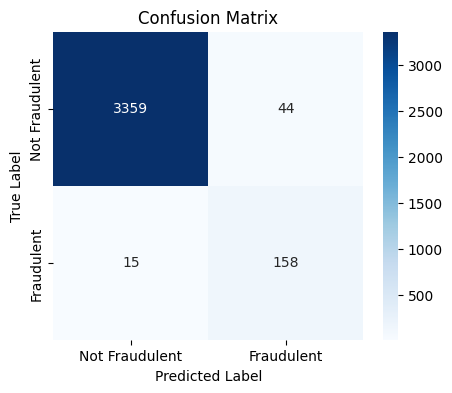

In [ ]:
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraudulent", "Fraudulent"], yticklabels=["Not Fraudulent", "Fraudulent"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

ROC-AUC Score: 0.9891


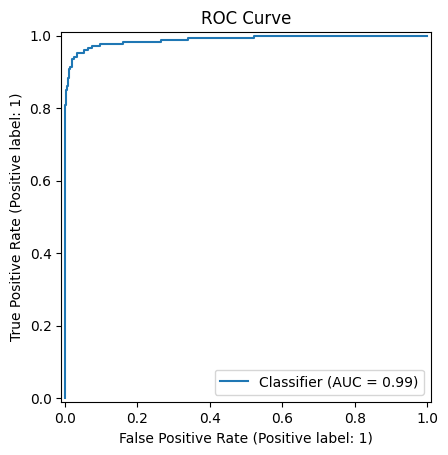

In [ ]:
roc_auc = roc_auc_score(true_labels, probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")

RocCurveDisplay.from_predictions(true_labels, probs)
plt.title("ROC Curve")
plt.show()

In [25]:
# Save model weights
torch.save(model.state_dict(), "/content/drive/MyDrive/bert_fake_job_classifier.pt")

In [23]:
for root, dirs, files in os.walk("/content"):  # start from /content in Colab
    for file in files:
        if "bert_fake_job_classifier" in file:  # or any part of the filename
            print(os.path.join(root, file))

/content/bert_fake_job_classifier.pt


In [24]:
import os
os.listdir()

['.config',
 'drive',
 'lightning_logs',
 'saved_fake_job_tokenizer',
 'bert_fake_job_classifier.pt',
 'sample_data']

In [26]:
# Save tokenizer separately (it’s still a Hugging Face tokenizer)
tokenizer.save_pretrained("/content/drive/MyDrive/saved_fake_job_tokenizer")

('/content/drive/MyDrive/saved_fake_job_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/saved_fake_job_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/saved_fake_job_tokenizer/vocab.txt',
 '/content/drive/MyDrive/saved_fake_job_tokenizer/added_tokens.json',
 '/content/drive/MyDrive/saved_fake_job_tokenizer/tokenizer.json')

In [ ]:
!pip install shap

import shap
explainer = shap.Explainer(model, tokenizer)
shap_values = explainer(["Apply now for immediate remote work benefits!"])




TypeError: BERTClassifier.forward() missing 1 required positional argument: 'attention_mask'

In [ ]:
!pip install shap --quiet

import shap
import torch
from transformers import AutoTokenizer

# load your trained model and tokenizer
model.eval()




BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
# define a wrapper that preprocesses text → tokens → model output
def f(texts):
    encoding = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**encoding)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return probs.cpu().numpy()


In [ ]:
masker = shap.maskers.Text(r"\W+")

# create explainer
explainer = shap.Explainer(f, masker)


# Example texts
sample_texts = [
    "Apply now for immediate remote work benefits!",
    "Software Engineer position available at Google, full-time with healthcare benefits."
]

# Compute SHAP values
shap_values = [explainer(text) for text in sample_texts]

# Visualize explanations
shap.plots.text(shap_values[0])
shap.plots.text(shap_values[1])

NameError: name 'predict_proba' is not defined

In [ ]:
masker = shap.maskers.Text(r"\W+")

# create explainer
explainer = shap.Explainer(f, masker)


# Example texts
sample_texts = [
    "Apply now for immediate remote work benefits!",
    "Software Engineer position available at Google, full-time with healthcare benefits."
]

# Compute SHAP values
shap_values = [explainer(text) for text in sample_texts]

# Visualize explanations
shap.plots.text(shap_values[0])
shap.plots.text(shap_values[1])

ValueError: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).

In [ ]:
explainer = shap.Explainer(f, shap.maskers.Text(tokenizer))

# explain a sample text
sample_text = ["Apply now for immediate remote work benefits!"]
shap_values = explainer(sample_text)

# visualize explanation
shap.plots.text(shap_values[0])

ValueError: text input must be of type `str` (single example), `list[str]` (batch or single pretokenized example) or `list[list[str]]` (batch of pretokenized examples).

In [ ]:
shap.plots.text(shap_values[0])